In [1]:
import numpy as np
import torch as pt
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
transforms_ = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAdjustSharpness(sharpness_factor=0.5),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4913997551666284, 0.48215855929893703, 0.4465309133731618), 
        std=(0.24703225141799082, 0.24348516474564, 0.26158783926049628),
    ),
])

test_transforms_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4913997551666284, 0.48215855929893703, 0.4465309133731618), 
        std=(0.24703225141799082, 0.24348516474564, 0.26158783926049628),
    ),
])

In [3]:
trainset = datasets.CIFAR10("./data", train=True, download=True, transform=transforms_)
testset = datasets.CIFAR10("./data", train=False, download=True, transform=test_transforms_)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 32

In [5]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader  = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [6]:
CLASSES = {v: k
    for k, v in trainset.class_to_idx.items()
}
CLASSES

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

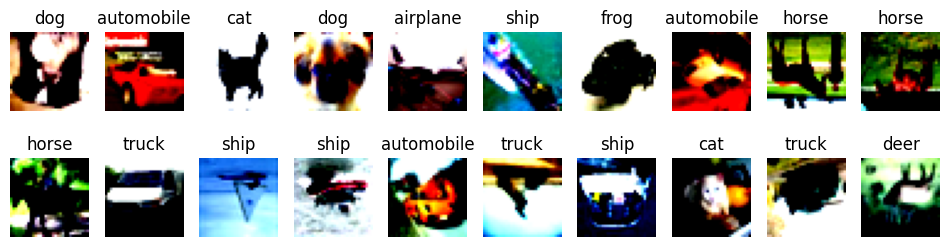

In [7]:
plt.figure(figsize=(12, 3), dpi=100)

images, labels = next(iter(trainloader))
for idx in range(20):
    plt.subplot(2, 10, idx+1)
    plt.imshow(images[idx].numpy().transpose(1, 2, 0))
    plt.axis("off")
    plt.title(CLASSES[labels[idx].item()])

In [8]:
print (f"Train dataset size: {len(trainloader.dataset)}")
print (f"Test dataset size: {len(testloader.dataset)}")

Train dataset size: 50000
Test dataset size: 10000


In [9]:
device = "cuda" if pt.cuda.is_available() else "cpu"

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # ((32-3 + 2*0) / 1) + 1 = 30, & Max Pool kernel size is 2x2  30 / 2 = 15
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
        ) # ((15-3 + 2*0) / 1) + 1 = 13
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
            nn.ReLU(),
        ) # ((13-3 + 2*0) / 1) + 1 = 11
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            nn.ReLU(),
        ) # ((11-3 + 2*0) / 1) + 1 = 9
        self.batch_norm2 = nn.BatchNorm2d(256)
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1),
            nn.ReLU(),
        ) # ((9-3 + 2*0) / 1) + 1 = 7
        self.fc1 = nn.Linear(in_features=512*7*7, out_features=4096) # (512 i.e. last layer output channel and 7*7 as per to the calculation)
        self.drop = nn.Dropout(0.4)
        self.batch_norm3 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=1024)
        self.fc3 = nn.Linear(in_features=1024, out_features=512)
        self.batch_norm4 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(in_features=512, out_features=len(CLASSES))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.batch_norm1(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.batch_norm2(out)
        out = self.layer5(out)
        out = out.view(-1, 512*7*7)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = self.batch_norm3(out)
        out = F.relu(self.fc2(out))
        out = self.drop(out)
        out = F.relu(self.fc3(out))
        out = self.drop(out)
        out = self.batch_norm4(out)
        out = self.fc4(out)
        return F.log_softmax(out)

In [11]:
model = Net().to(device)
optimizer = pt.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
epochs = 30

In [12]:
def criterion(pred, labels, size_average=None):
    return F.nll_loss(pred, labels, size_average=size_average)

In [13]:
def train(e):
    model.train(mode=True)
    train_loss = 0
    accuracy = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        pred = model(images)
        loss = criterion(pred, labels)
        pred = pred.data.max(1, keepdim=True)[1]
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        accuracy += pred.eq(labels.view_as(pred)).sum().item()
    train_loss /= len(trainloader.dataset)
    accuracy /= len(trainloader.dataset)
    print (f"Epoch: {e+1}/{epochs} Training loss: {loss.item():.6f} Training Accuracy: {accuracy:.6f}", end="; ")
    return train_loss

def test():
    model.eval()
    test_loss = 0
    test_acc = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        pred = model(images)
        test_loss += criterion(pred, labels, size_average=False).item() * images.size(0)
        pred = pred.data.max(1, keepdim=True)[1]
        test_acc += pred.eq(labels.view_as(pred)).sum().item()
    test_loss /= len(testloader.dataset)
    test_acc /= len(testloader.dataset)
    print (f"Validation loss: {test_loss:.6f} Validation Accuracy: {test_acc:.6f}")
    return test_acc, test_loss

In [14]:
train_loss, test_acc, test_loss = list(), list(), list()
for i in range(epochs):
    train_loss.append(train(i))
    tmp_acc, tmp_loss = test()
    test_acc.append(tmp_acc)
    test_loss.append(tmp_loss)

/tmp/ipykernel_2322/141775448.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Epoch: 1/30 Training loss: 1.338993 Training Accuracy: 0.334020; 

/home/parth/miniconda3/envs/env_pytorch_LTS/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Validation loss: 46.557443 Validation Accuracy: 0.466000
Epoch: 2/30 Training loss: 1.535957 Training Accuracy: 0.485240; Validation loss: 38.721439 Validation Accuracy: 0.557400
Epoch: 3/30 Training loss: 1.383720 Training Accuracy: 0.556140; Validation loss: 35.440278 Validation Accuracy: 0.610100
Epoch: 4/30 Training loss: 1.043826 Training Accuracy: 0.599080; Validation loss: 32.505249 Validation Accuracy: 0.637700
Epoch: 5/30 Training loss: 1.471112 Training Accuracy: 0.632320; Validation loss: 29.629583 Validation Accuracy: 0.674800
Epoch: 6/30 Training loss: 1.582410 Training Accuracy: 0.657680; Validation loss: 28.821593 Validation Accuracy: 0.680800
Epoch: 7/30 Training loss: 0.600881 Training Accuracy: 0.673060; Validation loss: 26.681559 Validation Accuracy: 0.704700
Epoch: 8/30 Training loss: 0.771460 Training Accuracy: 0.696160; Validation loss: 25.936382 Validation Accuracy: 0.713200
Epoch: 9/30 Training loss: 0.809937 Training Accuracy: 0.705880; Validation loss: 25.7476

Text(0.5, 1.0, 'Test Loss')

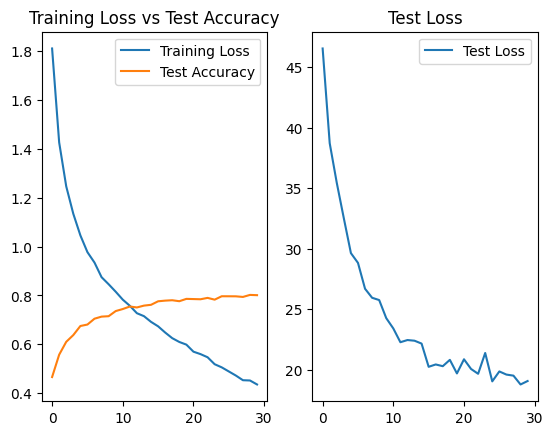

In [27]:
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss")
plt.plot(test_acc, label="Test Accuracy")
plt.legend(loc="upper right")
plt.title("Training Loss vs Test Accuracy")
plt.subplot(1, 2, 2)
plt.plot(test_loss, label="Test Loss")
plt.legend(loc="upper right")
plt.title("Test Loss")

In [16]:
pt.save(model, "./cifar-10_pytorch.pt")